Vamos a crear unos datos MUYYY sencillitos, y vamos a entrenar el modelo en RECONSTRUIRLOS solo. No vamos a pretender que haga nada más.   
Luego le meteremos lo de al AssDis.

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

# Los datos sinteticos SIN ANOMALÍAS

Voy a hacer un generador que nos de una secuencia regular, con puntos de anomalia


In [2]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


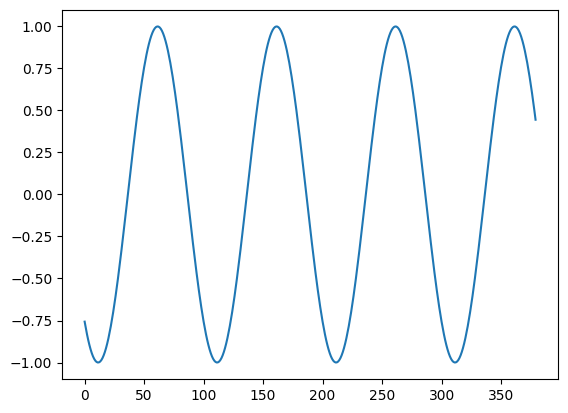

In [3]:
y=sinne(380,sf=0.1,f=1,phase=4)
plt.plot(y)

Y ahora el generador de datos. Le decimos que nos devuelva un batch de datos y nos lo da.

In [4]:
class Data(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y


In [5]:
win_size=600
data=Data(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

No es todo lo personalizable que querria, pero bien, ahora creamos la red. 

In [6]:
del modelo

NameError: name 'modelo' is not defined

In [6]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [2]:
def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




def count_parameters(model):
    
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total
#count_parameters(modelo)

## Entrenamiento
Añadimos en el entrenamiendo dos fases, una de mini y otra de max

Con el output tenemos que sacar: el error de reconstrucción y el AssDiss, y luego sacar dos function loses, una donde se minimiza y otra donde de maximiza.  

El calculo de las assdis lo vamos a poner en una funcion. 

In [3]:

def clip_gradients(model, max_norm, norm_type=2):
    """
    Clip gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.
        max_norm (float): The maximum allowed norm for the gradients.
        norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
    """
    # Recupera todos los gradientes de los parámetros del modelo
    gradients = [param.grad for param in model.parameters() if param.grad is not None]

    # Calcula la norma total de los gradientes
    total_norm = torch.norm(torch.stack([torch.norm(grad, norm_type) for grad in gradients]), norm_type)

    # Calcula el factor de escalado para recortar los gradientes
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        # Aplica el factor de escalado a los gradientes
        for grad in gradients:
            grad.mul_(clip_coef)




# def layer_association_discrepancy( Pl, Sl):
#     #Pl y Sl viene con dimension B,Head,Height,Width
#     B,Head,Height,_ = Pl.shape
#     result=torch.zeros(B,Head,Height)
#     for batch_size in range(B):
#         for head_size in range(Head):
#             rowwise_kl = lambda row: (F.kl_div(Pl[batch_size,head_size,row, :], Sl[batch_size,head_size,row, :]) + F.kl_div(Sl[batch_size,head_size,row, :], Pl[batch_size,head_size,row, :]))
#             ad_vector = torch.concat([rowwise_kl(row).unsqueeze(0) for row in range(Height)])
#             result[batch_size,head_size,:]=ad_vector
#     return result

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)



# def layer_association_discrepancy(Pl, Sl):
#     # Pl y Sl vienen con dimension B, Head, Height, Width
#     B, Head, Height, _ = Pl.shape

#     # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
#     kl1 = F.kl_div(Pl, Sl, reduction='none').mean(dim=-1)
#     kl2 = F.kl_div(Sl, Pl, reduction='none').mean(dim=-1)

#     # Sumar los KL Divergence calculados
#     ad_vector = kl1 + kl2

#     return ad_vector

def layer_association_discrepancy(Pl, Sl):
    # Pl y Sl vienen con dimension B, Head, Height, Width
    B, Head, Height, _ = Pl.shape

    # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
    kl1 = my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
    kl2 = my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))

    # Sumar los KL Divergence calculados
    ad_vector = kl1 + kl2

    return ad_vector



def association_discrepancy( P_list, S_list):

    return torch.stack([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

# (1 / len(P_list)) * sum(
#         [
#             torch.mean(layer_association_discrepancy(P, S),axis=0)#hacemos la media sobre todas las cabezas
#             for P, S in zip(P_list, S_list)
#         ]
#     )

def loss_function( x_hat, P_list, S_list, lambda_, x):
    frob_norm = ((x_hat - x)**2).mean()   #usamo MSE  #torch.linalg.matrix_norm(x_hat - x, ord="fro").mean() #norm L2 
    diss_norm=torch.mean(association_discrepancy(P_list, S_list))#torch.linalg.norm(, ord=1) # le añado esto para que se normaliza acros muestras 
    print(frob_norm,diss_norm)
    return frob_norm - (lambda_* diss_norm) #hacemos la suma de todos los valores absolutos y dividimos todo por el batchsize
    

def min_loss(output,P_layers,S_layers, x,lambda_):
    P_list = P_layers
    S_list = [S.detach() for S in S_layers]
    lambda_ = -lambda_
    return loss_function(output, P_list, S_list, lambda_, x)

def max_loss(output,P_layers,S_layers,x,lambda_):
    P_list = [P.detach() for P in P_layers]
    S_list = S_layers
    lambda_ = lambda_
    return loss_function(output, P_list, S_list, lambda_, x)

In [9]:
x_aux=next(iter(dataloader))
x_aux=x_aux.float().cuda()
print(x_aux.shape)

torch.Size([32, 600, 1])


## Pruebas mal


In [10]:
torch.mean(x_aux,axis=[2,0]).shape

torch.Size([600])

In [11]:
#pruebas porque salen nans
y_aux,series,prior,_=modelo(x_aux)
print(y_aux.shape)


torch.Size([32, 600, 1])


In [52]:
prior[0].shape

torch.Size([32, 2, 600, 600])

In [53]:
print(series[0].shape)

torch.Size([32, 2, 600, 600])


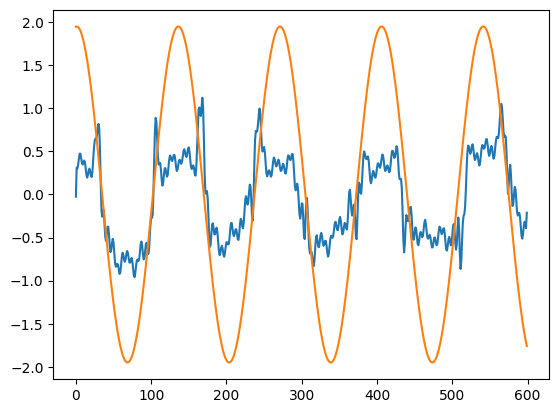

In [12]:
plt.plot(y_aux[7].squeeze().detach().cpu().numpy())
plt.plot(x_aux[7].squeeze().detach().cpu().numpy())

¿¿COmo aplicar esto si tenemos batches y heads??

In [85]:
del x_aux

In [14]:
aux1=torch.stack([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600),i) for i, j in zip(series,prior)]).mean(axis=[0,1])

In [17]:
aux1.mean(axis=[0,1])

tensor([8.5167, 8.0619, 7.9459, 7.8272, 7.5951, 7.3470, 7.1753, 7.1732, 7.3331,
        7.5755, 7.6740, 7.6553, 7.6207, 7.6757, 7.7317, 7.7407, 7.7063, 7.6611,
        7.5831, 7.5725, 7.6031, 7.6509, 7.6954, 7.6624, 7.5563, 7.4805, 7.4611,
        7.4680, 7.5398, 7.6066, 7.6018, 7.6263, 7.7376, 7.9838, 8.1917, 8.1954,
        8.0682, 7.9680, 7.9309, 7.9060, 7.8921, 7.8816, 7.8546, 7.8492, 7.8920,
        7.9543, 8.0408, 7.9970, 7.9013, 7.8024, 7.7025, 7.6858, 7.7606, 7.8253,
        7.8701, 7.8784, 7.8894, 7.9707, 8.0772, 8.1321, 8.1559, 8.1326, 8.0805,
        8.0412, 8.1200, 8.2622, 8.4153, 8.5139, 8.5051, 8.4191, 8.3663, 8.3589,
        8.3874, 8.4304, 8.3722, 8.3203, 8.3221, 8.3011, 8.3049, 8.3353, 8.3722,
        8.3108, 8.2373, 8.1566, 8.1356, 8.2207, 8.2873, 8.3069, 8.2825, 8.2096,
        8.1612, 8.2069, 8.2371, 8.2405, 8.2124, 8.1797, 8.2020, 8.2781, 8.3595,
        8.3988, 8.4022, 8.3016, 8.2313, 8.2909, 8.3949, 8.4419, 8.3301, 8.1789,
        8.1233, 8.1868, 8.2971, 8.3485, 

In [18]:
assdis=torch.sum([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600),i) for i, j in zip(series,prior)])
assdis.mean(0)

ValueError: only one element tensors can be converted to Python scalars

In [12]:
assdis2=association_discrepancy(prior,series)
assdis2

tensor([8.7781, 8.3854, 8.1935, 8.2383, 8.2531, 8.2740, 8.1185, 8.0714, 8.1005,
        8.1421, 8.2736, 8.4015, 8.3808, 8.2557, 8.1092, 8.1217, 8.1415, 8.1938,
        8.2265, 8.1540, 8.0823, 8.0458, 8.0808, 8.2399, 8.2134, 8.1882, 8.0741,
        8.0729, 8.1667, 8.2378, 8.4418, 8.4803, 8.4404, 8.4173, 8.4018, 8.5221,
        8.5236, 8.5149, 8.3987, 8.2740, 8.2826, 8.3613, 8.5215, 8.5841, 8.5256,
        8.4795, 8.3633, 8.4117, 8.4708, 8.5043, 8.4745, 8.3196, 8.2556, 8.2725,
        8.4438, 8.5826, 8.5476, 8.4119, 8.2342, 8.1248, 8.0634, 8.0909, 8.0973,
        8.1339, 8.1624, 8.2762, 8.3033, 8.3648, 8.4618, 8.4877, 8.4908, 8.3868,
        8.2993, 8.3569, 8.4370, 8.5755, 8.4773, 8.3829, 8.3128, 8.3061, 8.3689,
        8.3384, 8.2801, 8.3131, 8.3066, 8.4263, 8.4025, 8.4745, 8.5000, 8.4145,
        8.3942, 8.3723, 8.3879, 8.3895, 8.2586, 8.1863, 8.1157, 8.1453, 8.2991,
        8.5042, 8.5707, 8.3827, 8.2897, 8.3082, 8.3576, 8.4437, 8.3720, 8.3499,
        8.3553, 8.4424, 8.6077, 8.7945, 

In [14]:
torch.linalg.norm(assdis2,ord=1)

tensor(5026.4385, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
torch.linalg.norm(association_discrepancy(P_list, S_list), ord=1)

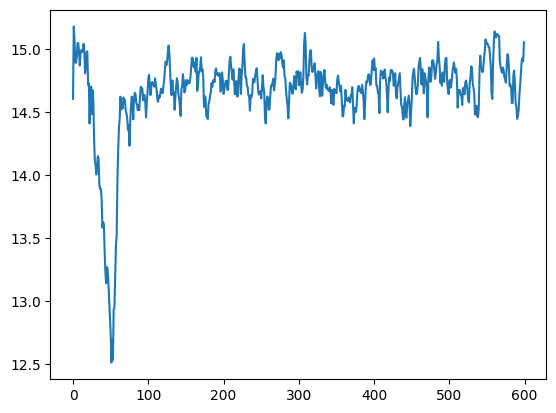

In [10]:
assdis2=association_discrepancy(prior,series)
plt.plot(assdis2.cpu().detach().numpy())

In [59]:
print(assdis2[assdis2.cpu()!=assdis.cpu()])
print(assdis[assdis2.cpu()!=assdis.cpu()])

tensor([-0.0124, -0.0116, -0.0109,  ..., -0.0137, -0.0137, -0.0123],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor([-0.0124, -0.0116, -0.0109,  ..., -0.0137, -0.0137, -0.0123],
       grad_fn=<IndexBackward0>)


In [52]:
assdis[0,0,50]

tensor(0.8152, grad_fn=<SelectBackward0>)

In [80]:
assdis

tensor([[3.7941e+01, 3.4628e+05, 3.4967e+05,  ..., 7.1304e+00, 6.7978e+00,
         6.6801e+00],
        [2.1250e+01, 4.8721e+01, 7.5540e+01,  ..., 1.2235e+01, 1.0733e+01,
         1.0075e+01],
        [3.5049e+05, 1.5828e+04, 1.0170e+05,  ..., 3.6465e+05, 3.6183e+05,
         3.4732e+05],
        ...,
        [6.0611e+01, 2.9842e+02, 5.5153e+02,  ..., 2.0121e+01, 1.6669e+01,
         3.6993e+01],
        [9.0725e+03, 3.5250e+05, 3.5192e+05,  ..., 1.2228e+01, 1.2015e+01,
         5.8743e+03],
        [2.5932e+01, 2.9729e+05, 3.4705e+05,  ..., 7.3222e+00, 6.9563e+00,
         7.2937e+00]], device='cuda:0', grad_fn=<AddBackward0>)

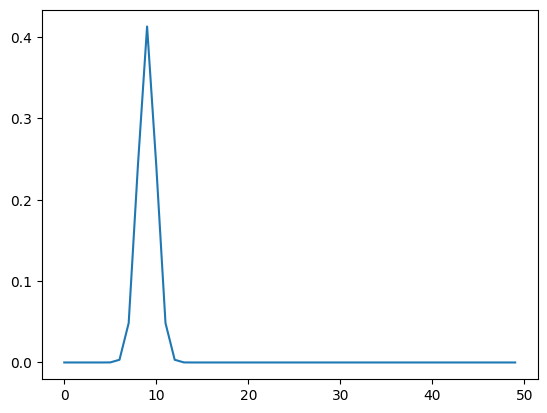

In [27]:
plt.plot(prior[0][12,1,9].cpu().detach().numpy()[:50])

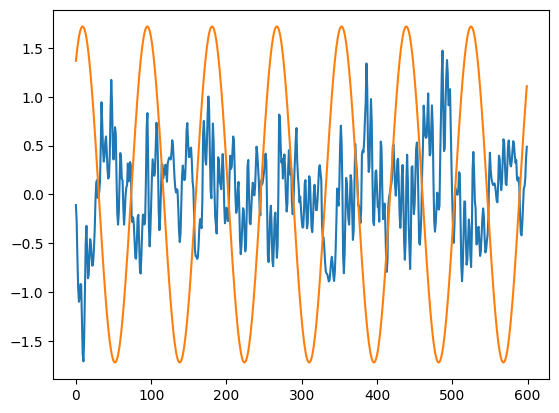

In [15]:
plt.plot(assdis[12].cpu().detach().numpy()-8)
plt.plot(x_aux[12].cpu().detach().numpy())

/home/arturoSF/.conda/envs/pytorch/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


torch.Size([600])


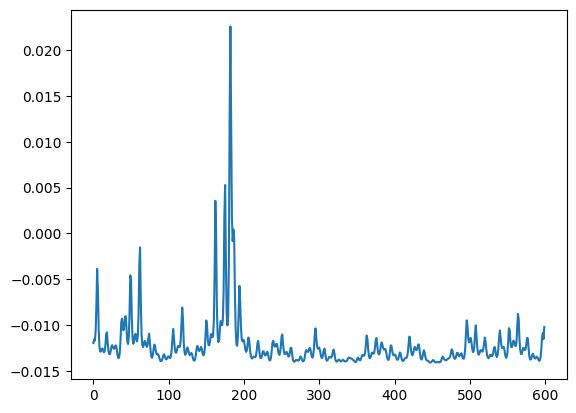

In [27]:
assdis=layer_association_discrepancy(prior[0][0,0],series[0][0,0])
print(assdis.shape)
plt.plot(assdis.detach().cpu().numpy())

In [10]:
a=association_discrepancy(prior,series)
a.shape

NameError: name 'prior' is not defined

In [62]:
prior[0].shape

torch.Size([32, 2, 600, 600])

In [17]:
aux=prior[0]/torch.unsqueeze(torch.sum(prior[0], dim=-1), dim=-1).repeat(1, 1, 1, 600)
aux.shape

torch.Size([32, 2, 600, 600])

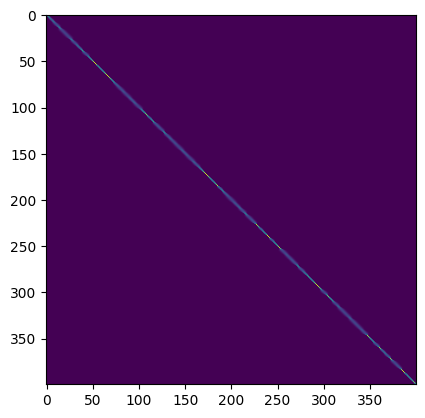

In [22]:
plt.imshow(aux[3,1].cpu().detach().numpy()[:400,:400])

## Seguimos el entrenamiento

In [21]:
del modelo

In [8]:
modelo=AnomalyTransformer.AnomalyTransformer(600, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [23]:
#veamos a ver si hay nans en los parámetros 
a=list(modelo.parameters())
if len([i for i in a if i.isnan().sum().item()!=0])>0:
    print("HAY NANS")

In [24]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-4)
modelo.train();


In [11]:
#lo vamos a hacer paso por paso


x_aux=next(iter(dataloader))
x_aux=x_aux.float().cuda()
print(x_aux.shape)

outputs, series, prior, _ = modelo(x_aux)
prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]

print(outputs.shape,len(series),series[0].shape ,len(prior) , prior[0].shape)

torch.Size([32, 600, 1])
torch.Size([32, 600, 1]) 2 torch.Size([32, 2, 600, 600]) 2 torch.Size([32, 2, 600, 600])


tensor([[[-1.2457],
         [-0.7826],
         [-0.8106],
         ...,
         [-0.0089],
         [ 0.1240],
         [-0.3946]],

        [[-1.2956],
         [-0.7836],
         [-0.7987],
         ...,
         [ 0.1260],
         [ 0.2409],
         [-0.3168]],

        [[-0.8853],
         [-0.6177],
         [-0.7039],
         ...,
         [-0.5409],
         [-0.3251],
         [-0.6104]],

        ...,

        [[-1.0066],
         [-0.7840],
         [-0.7939],
         ...,
         [-0.8743],
         [-0.8345],
         [-0.9007]],

        [[-1.4423],
         [-0.7885],
         [-0.7953],
         ...,
         [ 0.1939],
         [ 0.3084],
         [-0.3306]],

        [[-1.3037],
         [-0.8210],
         [-0.8248],
         ...,
         [ 0.1094],
         [ 0.1808],
         [-0.3736]]], device='cuda:0', grad_fn=<ViewBackward0>)


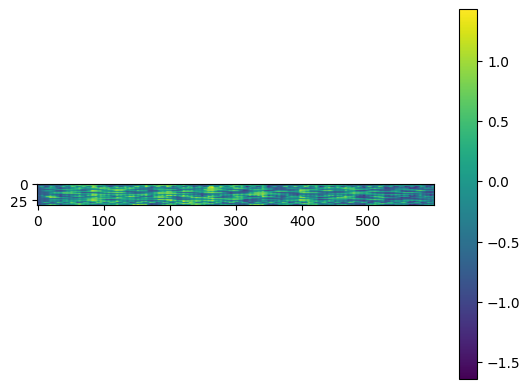

In [12]:
print(outputs)
plt.imshow(outputs.squeeze().cpu().detach().numpy())
plt.colorbar()

In [13]:
loss_min_1 = min_loss(outputs,prior,series, x_aux,3)
loss_min=loss_min_1
print(loss_min)


loss_max_1 = max_loss(outputs,prior,series, x_aux,3)
loss_max=loss_max_1
print(loss_max)

tensor(3.5327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(275.9006, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(831.2345, device='cuda:0', grad_fn=<SubBackward0>)
tensor(3.5327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(275.9006, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(-824.1691, device='cuda:0', grad_fn=<SubBackward0>)


In [24]:
criterion=nn.MSELoss()

In [39]:
loss_crit=criterion(outputs,x_aux)
loss_crit

tensor(1.3818, device='cuda:0', grad_fn=<MseLossBackward0>)

In [74]:
loss_crit.backward()

In [13]:
def lossmse(x,x_hat):
    return ((x - x_hat)**2).mean()

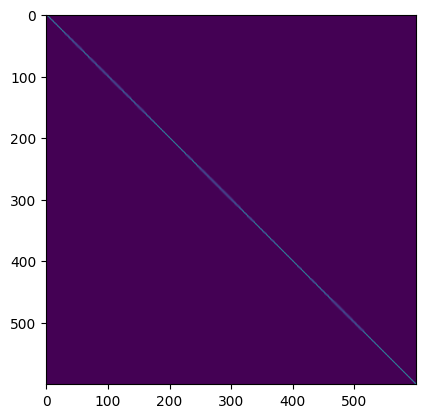

In [24]:
plt.imshow(prior[0][1,1].cpu().detach().numpy())

In [25]:
prior[0].sum(-1)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        ...,

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       device='cuda:0', grad_fn=<SumBackward1>)

In [33]:
loss=loss_function(x_hat=outputs, P_list=prior, S_list=series, lambda_=3, x=x_aux) #x_hat, P_list, S_list, lambda_, x 
#loss=((outputs - x_aux)**2).mean()
#loss=lossmse(outputs, x_aux)
loss

tensor(0.5884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(256.4609, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


tensor(-768.7944, device='cuda:0', grad_fn=<SubBackward0>)

tensor(44.5651, device='cuda:0', grad_fn=<SqrtBackward0>)


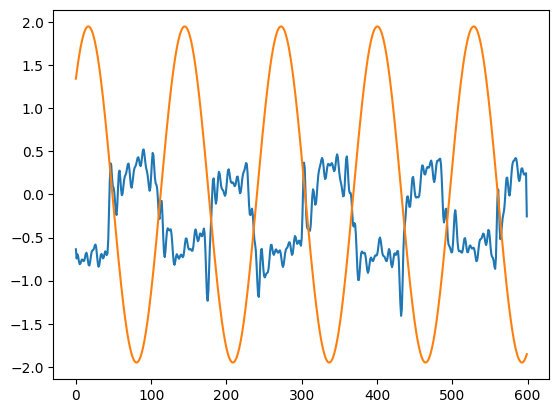

In [38]:
plt.plot(outputs[13].squeeze().detach().cpu().numpy())
plt.plot(x_aux[13].squeeze().detach().cpu().numpy())
print(torch.sqrt(((outputs[13]-x_aux[13])**2).sum()))

In [14]:
loss_min.backward(retain_graph=True)
loss_max.backward()
#loss.backward()

In [30]:
clip_gradients(modelo, max_norm=1)

In [15]:
optimizer.step()
#optimizer.zero_grad()

In [49]:
optimizer.zero_grad()

In [16]:
modelo(x_aux)

(tensor([[[-1.2429],
          [-0.7732],
          [-0.8010],
          ...,
          [-0.0130],
          [ 0.1199],
          [-0.3954]],
 
         [[-1.2936],
          [-0.7734],
          [-0.7882],
          ...,
          [ 0.1198],
          [ 0.2347],
          [-0.3192]],
 
         [[-0.8820],
          [-0.6110],
          [-0.6965],
          ...,
          [-0.5382],
          [-0.3231],
          [-0.6072]],
 
         ...,
 
         [[-0.9932],
          [-0.7700],
          [-0.7800],
          ...,
          [-0.8590],
          [-0.8189],
          [-0.8858]],
 
         [[-1.4403],
          [-0.7741],
          [-0.7812],
          ...,
          [ 0.1823],
          [ 0.2968],
          [-0.3337]],
 
         [[-1.3014],
          [-0.8111],
          [-0.8147],
          ...,
          [ 0.1034],
          [ 0.1749],
          [-0.3756]]], device='cuda:0', grad_fn=<ViewBackward0>),
 [tensor([[[[1.8798e-03, 9.9098e-04, 9.2239e-04,  ..., 3.0771e-03,
           

In [16]:
def get_gradients(model):
    """
    Get all gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.

    Returns:
        List[Tensor]: A list of gradient tensors for each model parameter.
    """
    gradients = [param.grad for param in model.parameters() if param.grad is not None]
    return gradients

gradients = get_gradients(modelo)
gradients


[tensor([[[-0.0854, -0.0863, -0.0838]],
 
         [[ 0.0166,  0.0138,  0.0125]],
 
         [[-0.0097, -0.0110, -0.0120]],
 
         [[ 0.0034,  0.0021, -0.0010]],
 
         [[ 0.0961,  0.0987,  0.0969]],
 
         [[ 0.0046,  0.0064,  0.0075]],
 
         [[-0.1254, -0.1217, -0.1139]],
 
         [[ 0.0492,  0.0489,  0.0462]],
 
         [[ 0.0855,  0.0855,  0.0804]],
 
         [[-0.1180, -0.1164, -0.1117]],
 
         [[-0.1250, -0.1225, -0.1154]],
 
         [[ 0.0524,  0.0501,  0.0472]],
 
         [[-0.0536, -0.0506, -0.0472]],
 
         [[-0.0488, -0.0503, -0.0486]],
 
         [[ 0.0715,  0.0669,  0.0624]],
 
         [[-0.0340, -0.0336, -0.0326]],
 
         [[-0.1149, -0.1094, -0.1018]],
 
         [[ 0.0313,  0.0285,  0.0263]],
 
         [[-0.0653, -0.0609, -0.0560]],
 
         [[ 0.0148,  0.0177,  0.0194]],
 
         [[ 0.0117,  0.0084,  0.0055]],
 
         [[-0.0639, -0.0627, -0.0597]],
 
         [[ 0.1189,  0.1142,  0.1101]],
 
         [[-0.0020, -0.0016, -0.00

In [81]:
gradients[-17]

tensor([ 0.0045, -0.0011, -0.0052, -0.0046, -0.0025,  0.0034, -0.0015,  0.0076,
        -0.0022,  0.0010, -0.0003, -0.0070,  0.0080, -0.0009,  0.0052, -0.0044,
        -0.0052,  0.0033,  0.0053, -0.0038,  0.0046, -0.0008, -0.0044, -0.0090,
         0.0060, -0.0042, -0.0024,  0.0008, -0.0023,  0.0046, -0.0035, -0.0055],
       device='cuda:0')

## Primer entrenamiento sin nada, solo con lambda 3 y sin lr schecdule ni clipping.

In [9]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=3

# Entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]
        loss_min = min_loss(outputs,prior,series, inputs,lambda_)
        loss_max = max_loss(outputs,prior,series, inputs,lambda_)

        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        #warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,15 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(1.5456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.1723, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.1723, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [1/125], Loss_min: 26.0625, Loss_max: -22.9713
tensor(1.1304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2541, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [2/125], Loss_min: 25.8928, Loss_max: -23.6319
tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4426, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4426, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [3/125], Loss_min: 26.5983, Loss_max: -24.0571
tensor(0.7595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4122, device='cuda:0', grad_fn=<MeanBackwar

In [21]:
del modelo
del inputs
torch.cuda.empty_cache()
gc.collect()

2639

In [10]:
#modelo.cuda()
a=next(iter(dataloader))
a1=a.float().to("cuda:0")
modelo.eval()
y=modelo(a1)


In [12]:
y[0].shape

torch.Size([32, 600, 1])

In [15]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [18]:
z=y[0].squeeze().cpu().detach().numpy()
series_aux=y[1][0].squeeze().cpu().detach().numpy()
prior_aux=y[2][0].squeeze().cpu().detach().numpy()
b=a1.squeeze().cpu().detach().numpy()

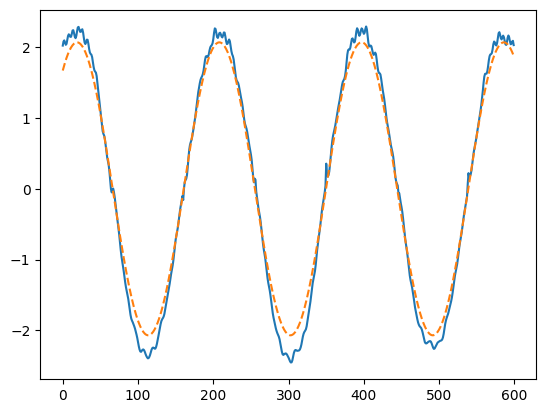

In [16]:
plt.plot(z[2])
plt.plot(b[2],"--")

In [17]:
z1.shape

(32, 2, 600, 600)

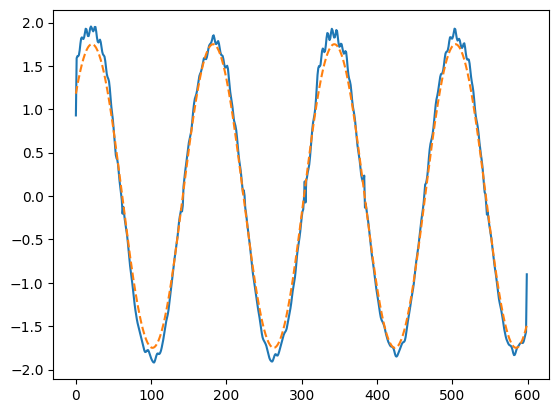

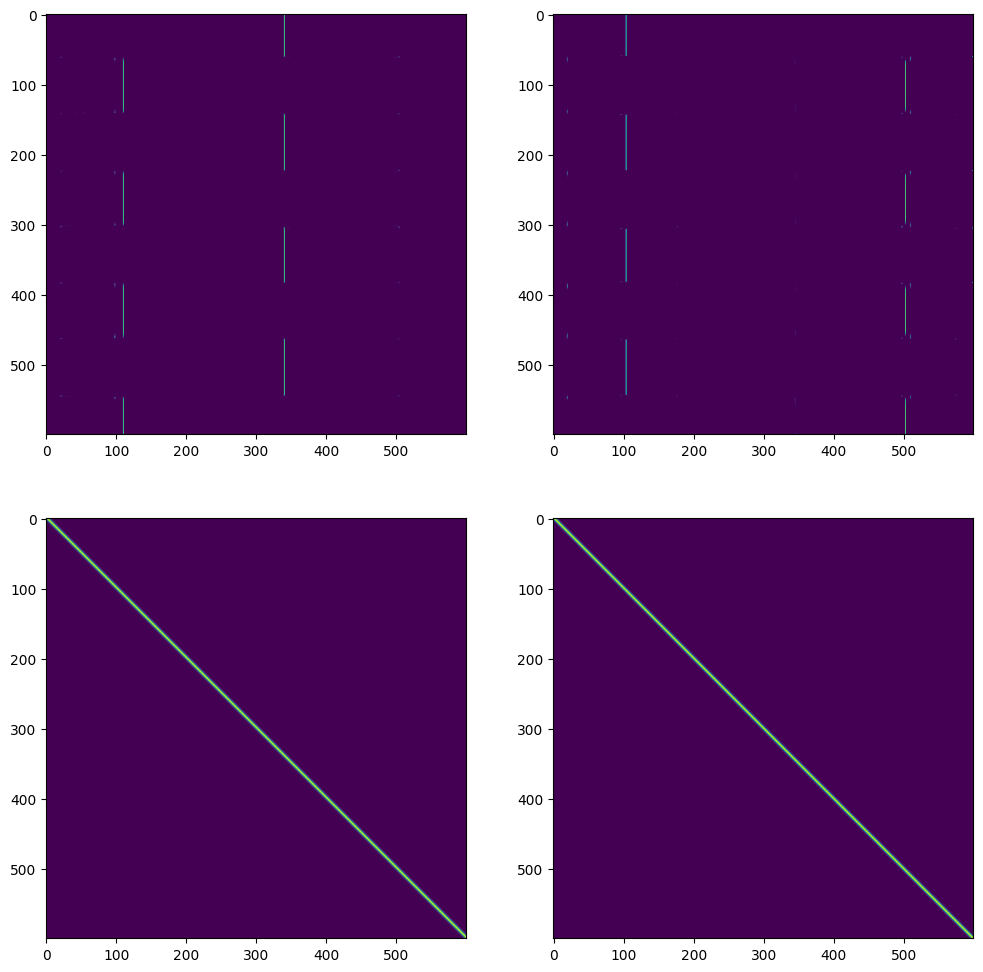

In [22]:
n=23

plt.plot(z[n])
plt.plot(b[n],"--")
plt.figure(figsize=(12,12))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(series_aux[n][i])
    plt.subplot(2,2,i+3)
    plt.imshow(prior_aux[n][i])

In [24]:
series_aux.shape

(32, 2, 600, 600)

In [30]:
y[1][0].shape

torch.Size([32, 2, 600, 600])

In [35]:
assdis=association_discrepancy(y[1],y[2]).cpu().detach().numpy()
assdis.shape

(32, 600)

In [45]:
def minmax(x):
    return (x-x.min())/(x.max()-x.min())

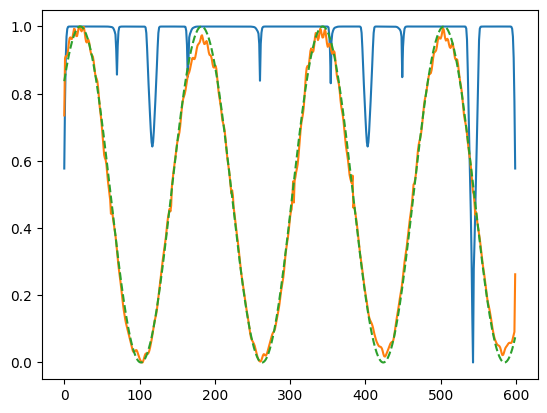

In [47]:
assdis=association_discrepancy(y[1],y[2]).cpu().detach().numpy()
plt.plot(minmax(assdis[1]))
plt.plot(minmax(z[n]))
plt.plot(minmax(b[n]),"--")

## Primer entrenamiento, segunda parte
Ahora en lugar de la reconstrucción de la misma señal, va a ser la reconstruccion de la señal flipeada. 


In [4]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [5]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


class DataFlip(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y, y.flip(0)


In [6]:
win_size=600
dataflip=DataFlip(win_size,4000)

dataloader=DataLoader(dataflip,batch_size=32,shuffle=True)

In [7]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [8]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=0

# Entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs,labels) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        labels=labels.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]
        loss_min = min_loss(outputs,prior,series, labels,lambda_)
        loss_max = max_loss(outputs,prior,series, labels,lambda_)

        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        #warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,15 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.5551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.5551, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [1/125], Loss_min: 1.3865, Loss_max: 1.3865
tensor(2.0922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4608, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [2/125], Loss_min: 2.0922, Loss_max: 2.0922
tensor(1.5530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2763, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2763, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [3/125], Loss_min: 1.5530, Loss_max: 1.5530
tensor(1.7077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2217, device='cuda:0', grad_fn=<MeanBackward0>)
tens

In [9]:
#modelo.cuda()
a_x,a_label=next(iter(dataloader))
a_x_cuda=a_x.float().to("cuda:0")
modelo.eval()
output,series_aux,prior_aux,_=modelo(a_x_cuda)


output=output.squeeze().cpu().detach().numpy()
series_aux=series_aux[0].squeeze().cpu().detach().numpy()
prior_aux=prior_aux[0].squeeze().cpu().detach().numpy()


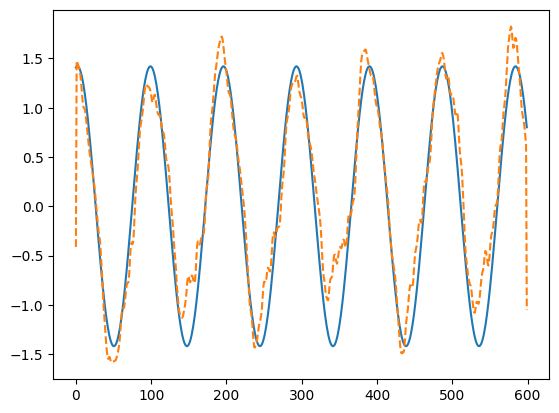

In [18]:
plt.plot(a_label[31])
plt.plot(output[31],"--")

## Primer entrenamiento tercera parte (con lr schedule, pero sin clipping)

Es exactamente lo mismo que antes, con el vector invertido, pero con lr schedule.

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [22]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


class Data(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y


def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def clip_gradients(model, max_norm, norm_type=2):
    """
    Clip gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.
        max_norm (float): The maximum allowed norm for the gradients.
        norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
    """
    # Recupera todos los gradientes de los parámetros del modelo
    gradients = [param.grad for param in model.parameters() if param.grad is not None]

    # Calcula la norma total de los gradientes
    total_norm = torch.norm(torch.stack([torch.norm(grad, norm_type) for grad in gradients]), norm_type)

    # Calcula el factor de escalado para recortar los gradientes
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        # Aplica el factor de escalado a los gradientes
        for grad in gradients:
            grad.mul_(clip_coef)




# def layer_association_discrepancy( Pl, Sl):
#     #Pl y Sl viene con dimension B,Head,Height,Width
#     B,Head,Height,_ = Pl.shape
#     result=torch.zeros(B,Head,Height)
#     for batch_size in range(B):
#         for head_size in range(Head):
#             rowwise_kl = lambda row: (F.kl_div(Pl[batch_size,head_size,row, :], Sl[batch_size,head_size,row, :]) + F.kl_div(Sl[batch_size,head_size,row, :], Pl[batch_size,head_size,row, :]))
#             ad_vector = torch.concat([rowwise_kl(row).unsqueeze(0) for row in range(Height)])
#             result[batch_size,head_size,:]=ad_vector
#     return result

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)



# def layer_association_discrepancy(Pl, Sl):
#     # Pl y Sl vienen con dimension B, Head, Height, Width
#     B, Head, Height, _ = Pl.shape

#     # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
#     kl1 = F.kl_div(Pl, Sl, reduction='none').mean(dim=-1)
#     kl2 = F.kl_div(Sl, Pl, reduction='none').mean(dim=-1)

#     # Sumar los KL Divergence calculados
#     ad_vector = kl1 + kl2

#     return ad_vector

def layer_association_discrepancy(Pl, Sl):
    # Pl y Sl vienen con dimension B, Head, Height, Width
    B, Head, Height, _ = Pl.shape

    # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
    kl1 = my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
    kl2 = my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))

    # Sumar los KL Divergence calculados
    ad_vector = kl1 + kl2

    return ad_vector



def association_discrepancy( P_list, S_list):

    return torch.stack([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

# (1 / len(P_list)) * sum(
#         [
#             torch.mean(layer_association_discrepancy(P, S),axis=0)#hacemos la media sobre todas las cabezas
#             for P, S in zip(P_list, S_list)
#         ]
#     )

def loss_function( x_hat, P_list, S_list, lambda_, x):
    frob_norm = ((x_hat - x)**2).mean()   #usamo MSE  #torch.linalg.matrix_norm(x_hat - x, ord="fro").mean() #norm L2 
    diss_norm=torch.mean(association_discrepancy(P_list, S_list))#torch.linalg.norm(, ord=1) # le añado esto para que se normaliza acros muestras 
    print(frob_norm,diss_norm)
    return frob_norm - (lambda_* diss_norm) #hacemos la suma de todos los valores absolutos y dividimos todo por el batchsize
    

def min_loss(output,P_layers,S_layers, x,lambda_):
    P_list = P_layers
    S_list = [S.detach() for S in S_layers]
    lambda_ = -lambda_
    return loss_function(output, P_list, S_list, lambda_, x)

def max_loss(output,P_layers,S_layers,x,lambda_):
    P_list = [P.detach() for P in P_layers]
    S_list = S_layers
    lambda_ = lambda_
    return loss_function(output, P_list, S_list, lambda_, x)


In [23]:
win_size=600
data=Data(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

In [34]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [35]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=1

# Entrenamiento
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]
        loss_min = min_loss(outputs,prior,series, inputs,lambda_)
        loss_max = max_loss(outputs,prior,series, inputs,lambda_)

        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,6 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(1.6430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.8944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.6430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.8944, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [1/125], Loss_min: 10.5373, Loss_max: -7.2514
tensor(1.9131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.1292, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.1292, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [2/125], Loss_min: 11.0423, Loss_max: -7.2161
tensor(1.3403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0161, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0161, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [3/125], Loss_min: 10.3564, Loss_max: -7.675

In [38]:
#modelo.cuda()
a_x=next(iter(dataloader))
a_x_cuda=a_x.float().to("cuda:0")
modelo.eval()
output,series_aux,prior_aux,_=modelo(a_x_cuda)


output=output.squeeze().cpu().detach().numpy()
series_aux=series_aux[0].squeeze().cpu().detach().numpy()
prior_aux=prior_aux[0].squeeze().cpu().detach().numpy()


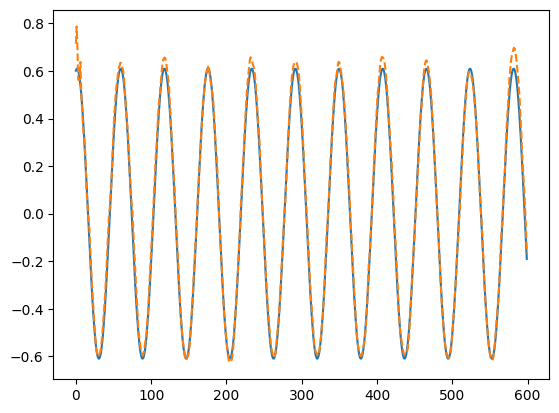

In [55]:
n=11
plt.plot(a_x[n])
plt.plot(output[n],"--")